# Imports

In [1]:
!pip install autogluon==0.8.2
!pip install catboost==1.1.1
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install scikit-learn

# We use these following versions of the models:
# autogluon==0.8.2
# catboost==1.1.1

# Note: For mac users, you need to run brew install libomp. (Might need to reinstall it https://auto.gluon.ai/stable/install.html)


In [2]:

import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
import os
import matplotlib.pyplot as plt
from typing import List


# Load datasets

In [3]:

folder = '../data/'
A = folder + 'A/'
B = folder + 'B/'
C = folder + 'C/'

XTRO = 'X_train_observed.parquet'
XTRE = 'X_train_estimated.parquet'
XTEE = 'X_test_estimated.parquet'
Y = 'train_targets.parquet'

relative_filepaths = {"A": A, "B": B, "C": C}

def get_df_from_parquet(filepath: str) -> pd.DataFrame:
    """
    Returns DataFrame when given filepath to .parquet file
    """
    return pd.read_parquet(filepath)

def merge_x(xo_path, xe_path):
    xo = get_df_from_parquet(xo_path)
    xe = get_df_from_parquet(xe_path)
    xo['estimated'] = 0
    xe['estimated'] = 1
    xo['estimation_calc_forecast_difference'] = 0
    time_diff = []
    for i in range(len(xe)):
        time_diff.append(abs((xe['date_forecast'].iloc[i] - xe['date_calc'].iloc[i]).seconds))
    xe['estimation_calc_forecast_difference'] = time_diff

    if 'date_calc' in xe.columns:
         xe.drop(columns=['date_calc'], inplace=True)
    x_train = pd.concat([xo, xe])
    return x_train

def append_x_y(x_list, y_list, merge, path):
    if merge:
        x_list.append(merge_x(path+XTRO, path+XTRE))
    else: 
        x_list.append(get_df_from_parquet(path+XTRO)) #appending observed X train
        x_list.append(get_df_from_parquet(path+XTRE)) #appendeing estimated X train
    y_list.append(get_df_from_parquet(path+Y)) # appending target Y

def get_training_data(location: str or list = None, merge: bool = True) -> List[List[pd.DataFrame]]:
    """
    Returns tuple with merged x_train data for given location(s) in a list and corresponding list of targets

    OR if none given, returns all locations x_train_merged per location 
    
    **in order A, B, C <----------NB!** or order given. 

    RETURNS: List[List[x_train: pd.DataFrame], List[y_target: pd.DataFrame]]

    NOTE: If merge = False the list returned is [x_train_observed_A, x_train_estimated_A,...]
    """
    ### dealing with current working directory for relative paths ###
    # cwd_old = os.getcwd()
    # file_loc = os.path.abspath(__file__)
    # cwd_new = os.path.dirname(file_loc)
    # os.chdir(cwd_new)
    
    x_train_list = []
    y_target_list = []
    
    if location == None: 
        for i in relative_filepaths:
            path = relative_filepaths[i]
            append_x_y(x_train_list, y_target_list, merge, path)
    
    elif type(location) == str:
        try:
            path = relative_filepaths[location] 
            append_x_y(x_train_list, y_target_list, merge, path)
        except Exception as e:
            print(f'\nProbaly no matching location for passed string: {location}')
            raise Exception(e)
        
    
    elif type(location) == list:
        for loc in location: 
            try: 
                path = relative_filepaths[loc]
                append_x_y(x_train_list, y_target_list, merge, path)
            except Exception as e:
                print(f'\nProbaly no matching location for passed strings:{location}')
                raise Exception(e)
    
    # os.chdir(cwd_old)
    ### returning working directory ###
    return [x_train_list, y_target_list]

def get_test_data(location: str or list = None) -> List[pd.DataFrame]:
    """
    Returns list with x_test data for given location(s) in a list

    OR if none given, returns all locations x_testper location 
    
    **in order A, B, C <----------NB!** or order given. 

    RETURNS: List[x_test: pd.DataFrame]
    """
    ### dealing with current working directory for relative paths ###
    # cwd_old = os.getcwd()
    # file_loc = os.path.abspath(__file__)
    # cwd_new = os.path.dirname(file_loc)
    # os.chdir(cwd_new)
    
    x_list = []
    
    if location == None: 
        for i in relative_filepaths:
            path = relative_filepaths[i]
            xt = get_df_from_parquet(path+XTEE)
            xt['estimated'] = 1
            time_diff = []
            for i in range(len(xt)):
                time_diff.append(abs((xt['date_forecast'].iloc[i] - xt['date_calc'].iloc[i]).seconds))
            xt['estimation_calc_forecast_difference'] = time_diff
            x_list.append(xt)
    
    elif type(location) == str:
        try:
            path = relative_filepaths[location] 
            x_list.append(get_df_from_parquet(path+XTEE))
        except Exception as e:
            print(f'\nProbaly no matching location for passed string: {location}')
            raise Exception(e)
        
    
    elif type(location) == list:
        for loc in location: 
            try: 
                path = relative_filepaths[loc]
                x_list.append(get_df_from_parquet(path+XTEE))
            except Exception as e:
                print(f'\nProbaly no matching location for passed strings:{location}')
                raise Exception(e)
    
    #os.chdir(cwd_old)
    for x in x_list:
        if 'date_calc' in x:
            x.drop(columns=['date_calc'], inplace=True)
    ### returning working directory ###
    return x_list

dataframes = get_training_data()
X_frames_train = dataframes[0]
Y_frames_train = dataframes[1]
X_frames_test = get_test_data()



In [4]:
XTRA = X_frames_train[0]
XTRB = X_frames_train[1]
XTRC = X_frames_train[2]

YA = Y_frames_train[0]
YB = Y_frames_train[1]
YC = Y_frames_train[2]


In [5]:
print("A: \n", len(XTRA))
ind = XTRA[(XTRA['date_forecast'] == pd.to_datetime('2022-10-21 00:00:00'))].index
print(ind)
XTRA = XTRA.drop(ind).reset_index(drop=True)
print(len(XTRA))



A: 
 136245
Int64Index([118664], dtype='int64')
136244


In [6]:
print("B: \n", len(XTRB))
ind = XTRB[(XTRB['date_forecast'] == pd.to_datetime('2022-05-02 21:00:00'))].index
print(ind)
XTRB = XTRB.drop(ind).reset_index(drop=True)
print(len(XTRB))

print("C: \n",len(XTRC))
ind = XTRC[(XTRC['date_forecast'] == pd.to_datetime('2022-04-25 21:00:00'))].index
print(ind)
XTRC = XTRC.drop(ind).reset_index(drop=True)
print(len(XTRC))


B: 
 134505
Int64Index([116916], dtype='int64')
134504
C: 
 134401
Int64Index([116244], dtype='int64')
134400


# Data clean up

<Axes: title={'center': 'Target C Clean'}, xlabel='time'>

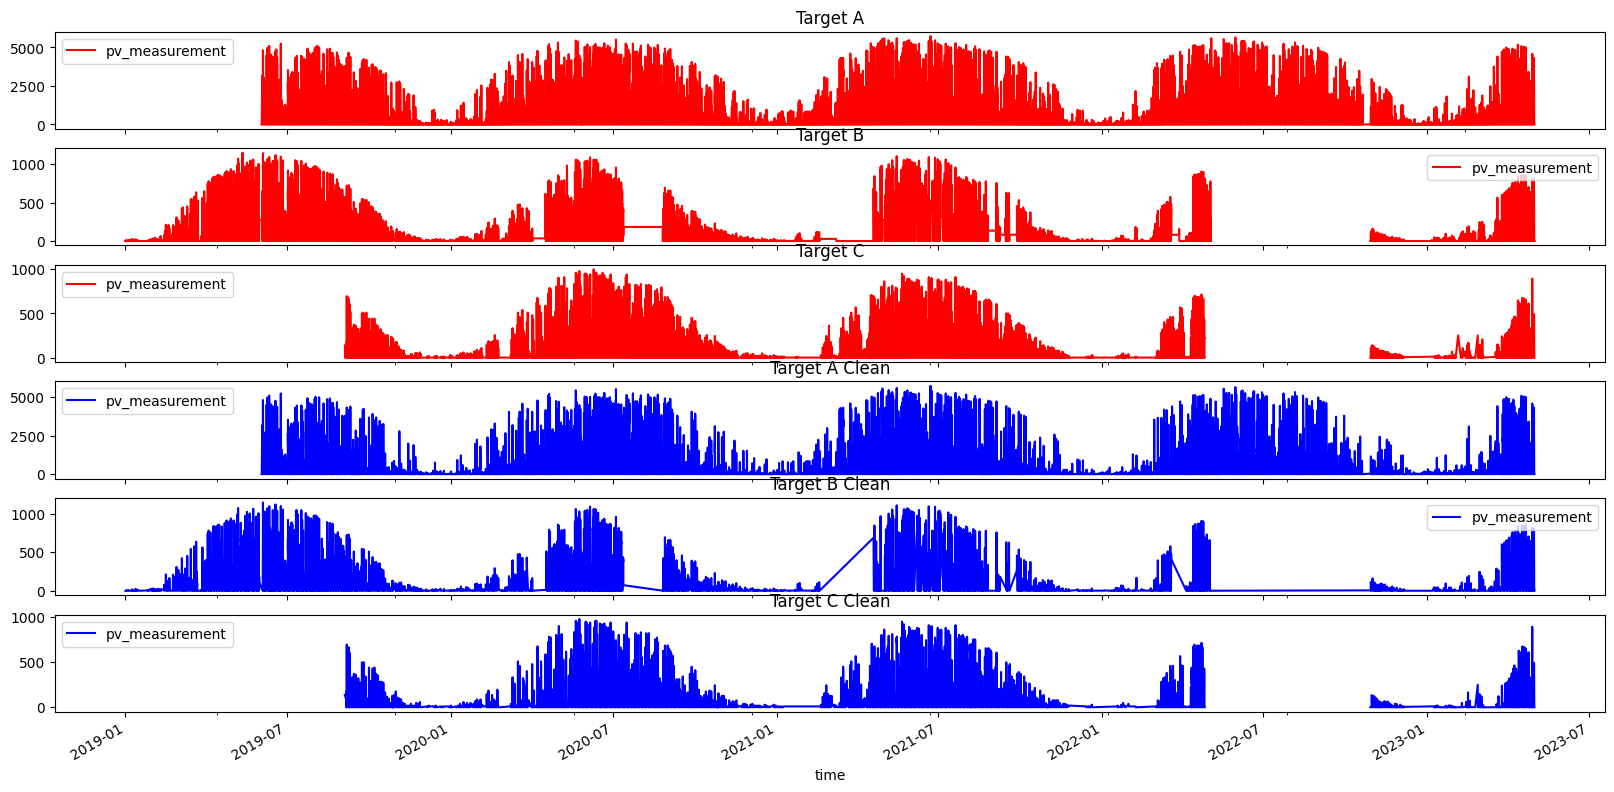

In [7]:
def fix_y_holes(y: pd.DataFrame) -> pd.DataFrame:
    Y = y
    drop_val = None
    zero_counter = 0
    index_dropper = []
    for i in range(1, len(Y)-4): # Since we match on 4 consecutive values.
        if Y['pv_measurement'].iloc[i] != 0:
            if zero_counter > 23:
                zero_list = list(range(i-zero_counter, i))
                index_dropper.extend(zero_list)
                zero_counter = 0
            if (Y['pv_measurement'].iloc[i] == Y['pv_measurement'].iloc[i+1] and Y['pv_measurement'].iloc[i+1] == Y['pv_measurement'].iloc[i+2] and Y['pv_measurement'].iloc[i+2] == Y['pv_measurement'].iloc[i+3]):
                drop_val = Y['pv_measurement'].iloc[i]
        if Y['pv_measurement'].iloc[i] == 0:
            zero_counter += 1
        if Y['pv_measurement'].iloc[i] == drop_val:
            index_dropper.append(i)
        else:
            if drop_val != None:
                drop_val = None
    return Y.drop(index_dropper)
    
    
fig, axs = plt.subplots(6, 1, figsize=(20, 10), sharex=True)
YA[['time', 'pv_measurement']].set_index('time').plot(ax=axs[0], title='Target A', color='red')
YB[['time', 'pv_measurement']].set_index('time').plot(ax=axs[1], title='Target B', color='red')
YC[['time', 'pv_measurement']].set_index('time').plot(ax=axs[2], title='Target C', color='red')


YA = fix_y_holes(YA)
YB = fix_y_holes(YB)
YC = fix_y_holes(YC)

YA[['time', 'pv_measurement']].set_index('time').plot(ax=axs[3], title='Target A Clean', color='blue')
YB[['time', 'pv_measurement']].set_index('time').plot(ax=axs[4], title='Target B Clean', color='blue')
YC[['time', 'pv_measurement']].set_index('time').plot(ax=axs[5], title='Target C Clean', color='blue')



# Data Aggregation

In [8]:
# Making sure that target values line up with x_values

def stocastic_median(x_list):
    s = np.median(x_list)
    return int(s)


def gen_agg(df: pd.DataFrame, agg_type, batch_size: int = 4, merge_on = 'first') -> pd.DataFrame:
    """
    Pass dataframe WITH date_forecast value and choose aggregation type by passing string to 'agg_type'
    """
    agg_func = {col: agg_type for col in df.columns[1:]} # [1:] assumes 'date_forecast' is first
    return df.groupby(df.index // batch_size).agg({**{'date_forecast': merge_on}, **agg_func})

categorical_col = ['dew_or_rime:idx', 'precip_type_5min:idx', 'is_day:idx', 'is_in_shadow:idx']

def aggregate_correct_x(x: pd.DataFrame) -> pd.DataFrame:
   '''
   Takes a given dataframe and returns an aggregated dataframe based on selected categorical functions. 
   Assumes grouping of 4.
   '''
   categorical = x[["date_forecast"] + categorical_col]
   mean = x.drop(columns=categorical_col)

   categorical = gen_agg(categorical, agg_type=stocastic_median, merge_on = 'first')
   mean = gen_agg(mean, "mean", merge_on = 'first')

   return pd.merge(categorical, mean, on="date_forecast")

def data_allign(x_train, y_train):

  y_train.dropna(inplace=True)
  x_train = aggregate_correct_x(x_train)
  combined_data = pd.merge(x_train, y_train, left_on='date_forecast', right_on='time')
  y_train = combined_data['pv_measurement']

  if 'time' and 'pv_measurement' in combined_data.columns:
    combined_data.drop(columns=['time', 'pv_measurement'], inplace=True)
    
  return combined_data, y_train

X_train = [XTRA, XTRB, XTRC]
Y_train = [YA, YB, YC]

for i in range(len(X_train)):
    X_train[i], Y_train[i] = data_allign(X_train[i], Y_train[i])

for j in range(len(X_frames_test)):
    X_frames_test[j] = aggregate_correct_x(X_frames_test[j])


In [9]:
#Verify length matches
for x in range(len(X_train)):
    print("x,y: ", len(X_train[x]), len(Y_train[x]))


x,y:  18071 18071
x,y:  12443 12443
x,y:  10129 10129


# Feature engineering

### Timeseasonality

In [10]:

## We now need functions for assigning daily and YEARly cycles (described in datanalysis docu on Peter branch)
# plus 2 avoids 0 and negative values but we ignore this here since it allready normalises the data
DAY = 24*60*60
YEAR = (365.2425)*DAY
SHIFT = 0 #possible to shift oscilation to avoid 0 and or negative values.

# Conversion datetime -> unix_time
def get_unixtime(datetime: pd.Series) -> pd.Series:
    unixtime = (datetime - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')
    return unixtime

# functions for creating seasonality:
def sinus_day(unix_time):
    return SHIFT + np.sin(unix_time * (2 * np.pi / DAY)) # since it is seconds since 1.1.1970 we divide by seconds in a DAY to get seasonal changes throughout the dat

def sinus_year(unix_time):
    return SHIFT + np.sin(unix_time * (2 * np.pi / YEAR))

def cosinus_day(unix_time):
    return SHIFT + np.cos(unix_time * (2 * np.pi / DAY))

def cosinus_year(unix_time):
    return SHIFT + np.cos(unix_time * (2 * np.pi / YEAR))

# function for returning two series with the daily cycles (sine and cosine)
def get_daycycle(unixtime: pd.Series) -> List[pd.Series]:
    sinus_daytime = unixtime.apply(sinus_day)
    sinus_daytime = sinus_daytime.rename('sinus_day') 
    cosinus_daytime = unixtime.apply(cosinus_day)
    cosinus_daytime = cosinus_daytime.rename('cosinus_day')
    return [sinus_daytime, cosinus_daytime]

# Function for returning two series with the yearly cycles
def get_yearcycle(unixtime: pd.Series) -> List[pd.Series]:
    sinus_yeartime = unixtime.apply(sinus_year)
    sinus_yeartime = sinus_yeartime.rename('sinus_year')
    cosinus_yeartime = unixtime.apply(cosinus_year)
    cosinus_yeartime = cosinus_yeartime.rename('cosinus_year')
    return [sinus_yeartime, cosinus_yeartime]

def append_seasonal_columns(df: pd.DataFrame, time_column: str = 'date_forecast') -> pd.DataFrame:
    """
    returns joined Dataframe with seasonal data. Does not drop time_column
    """
    # check that time column exists
    if time_column not in df.columns: 
        raise Exception(f"The timecolumn passed: {time_column}, is not part of the dataset passed.")
    
    if not np.issubdtype(df[time_column], np.datetime64):
        raise Exception(f'Passed timecolumn must be of numpy datetime64. Passed type is {df[time_column].dtype()}')
    
    unixtime = get_unixtime(df[time_column])
    day_sin, day_cos = get_daycycle(unixtime)
    year_sin, year_cos = get_yearcycle(unixtime)
    df = df.join([day_sin, day_cos, year_sin, year_cos])
    
    return df


### One-Hot-Encoding

In [11]:

def one_hot_encode(df: pd.DataFrame, col_list: [str]):
  for col in col_list:
    column_to_encode = df[col]
    df_encoded = pd.get_dummies(column_to_encode, prefix=col) # Convert categorical variable into dummy/indicator variables
    df.drop(col, axis=1, inplace=True)
    df_encoded_binary = df_encoded.astype(int) # Convert to binary from boolean
    df = pd.concat([df, df_encoded_binary], axis=1) # Concatenate dataframes
  return df


### Date forecast columns

In [12]:
def date_forecast_columns(df: pd.DataFrame):

  date_forecast = df['date_forecast']
  
  df['year'] = date_forecast.dt.year
  df['month'] = date_forecast.dt.month
  df['day'] = date_forecast.dt.day
  df['hours'] = date_forecast.dt.hour
  df['day_of_week'] = date_forecast.dt.dayofweek
  df['day_of_year'] = date_forecast.dt.dayofyear
  df['week_of_year'] = date_forecast.dt.isocalendar().week

  return df


In [13]:

def more_features(df: pd.DataFrame) -> pd.DataFrame:
    # Convert the 'date_forecast' to datetime and set it as index
    df['date_forecast'] = pd.to_datetime(df['date_forecast'])
    df.set_index('date_forecast', inplace=True)
    df.sort_index(inplace=True)
    # Now apply the rolling function
    df['max_air_density_3h'] = df['air_density_2m:kgm3'].rolling('3h').max()
    df['min_air_density_3h'] = df['air_density_2m:kgm3'].rolling('3h').min()
    df['total_solar_rad_1h'] = df['direct_rad_1h:J'] + df['diffuse_rad_1h:J']
    df['total_wind_speed_10m'] = (df['wind_speed_u_10m:ms']**2 + df['wind_speed_v_10m:ms']**2)**0.5
    df['total_snow_1h'] = df[['fresh_snow_1h:cm', 'snow_melt_10min:mm']].sum(axis=1)
    df['pressure_variation_3h'] = df['sfc_pressure:hPa'].diff(periods=3)

    return df

for i in range(len(X_train)):
    X_train[i] = append_seasonal_columns(X_train[i])
    X_train[i] = date_forecast_columns(X_train[i])


for i in range(len(X_frames_test)):
    X_frames_test[i] = append_seasonal_columns(X_frames_test[i])
    X_frames_test[i] = date_forecast_columns(X_frames_test[i])  

# THIS SECTION CAN ONLY WORK IF THE PREVIOUS AGGREGATION IS DONE INDIVIDUALLY FOR CATEGORICAL DATA

def fix_categorical(train: pd.DataFrame, test: pd.DataFrame):
    temp = pd.concat([train, test], ignore_index=True)
    index_train = temp[(temp['date_forecast'] < test['date_forecast'].iloc[0])].index
    return temp.drop(index_train)

OH_columns = ['dew_or_rime:idx', 'precip_type_5min:idx']

for i in range(len(X_frames_test)):
    X_train[i] = one_hot_encode(X_train[i],OH_columns)
    X_frames_test[i] = one_hot_encode(X_frames_test[i], OH_columns)
    X_frames_test[i] = fix_categorical(X_train[i], X_frames_test[i])
    X_train[i] = more_features(X_train[i])
    X_frames_test[i] = more_features(X_frames_test[i])


# Data cleaning

In [14]:
# Show null values for all training sets

count_a = X_train[0].isna().sum()
count_b = X_train[1].isna().sum()
count_c = X_train[2].isna().sum()

count_a.rename("A", inplace=True)
count_b.rename("B", inplace=True)
count_c.rename("C", inplace=True)

df = pd.merge(count_a, count_b, left_index=True, right_index=True)
df = pd.merge(df, count_c, left_index=True, right_index=True)

df[(df['A'] != 0) | (df['B'] != 0) | (df['C'] != 0)]


,A,B,C
ceiling_height_agl:m,3525,2104,2289
cloud_base_agl:m,1322,910,873
snow_density:kgm3,17719,12166,10116
pressure_variation_3h,3,3,3


In [15]:
# Show null values for all test sets

count_a = X_frames_test[0].isna().sum()
count_b = X_frames_test[1].isna().sum()
count_c = X_frames_test[2].isna().sum()

count_a.rename("A", inplace=True)
count_b.rename("B", inplace=True)
count_c.rename("C", inplace=True)

df = pd.merge(count_a, count_b, left_index=True, right_index=True)
df = pd.merge(df, count_c, left_index=True, right_index=True)

df[(df['A'] != 0) | (df['B'] != 0) | (df['C'] != 0)]


,A,B,C
ceiling_height_agl:m,188,180,202
cloud_base_agl:m,70,65,88
snow_density:kgm3,720,720,720
dew_or_rime:idx_-1,720,720,0
precip_type_5min:idx_2,720,720,720
precip_type_5min:idx_3,720,720,720
pressure_variation_3h,3,3,3


In [16]:

def combine_features(df, listOfFeaturesToCombine):
    for features in listOfFeaturesToCombine:
        new_col_name = features[0] + '_mean'
        df[new_col_name] = df[features].mean(axis=1)
    return df

listOfFeaturesToCombine = [['msl_pressure:hPa', 'pressure_100m:hPa', 'pressure_50m:hPa', 'sfc_pressure:hPa'],
                            ["diffuse_rad:W", "direct_rad:W"], 
                           ['effective_cloud_cover:p', 'total_cloud_cover:p']
                    ]
for i in range(len(X_train)):
    X_train[i] = combine_features(X_train[i], listOfFeaturesToCombine)
    X_frames_test[i] = combine_features(X_frames_test[i], listOfFeaturesToCombine)



In [17]:
X_train_ag = [X_train[0].__deepcopy__(), X_train[1].__deepcopy__(), X_train[2].__deepcopy__()]
X_frames_test_ag = [X_frames_test[0].__deepcopy__(), X_frames_test[1].__deepcopy__(), X_frames_test[2].__deepcopy__()]


In [18]:
def multiply_columns(A: pd.Series, B: pd.Series) -> pd.Series:
    '''
    Given two pandas series, returns a series with multiplied values. 

    NB! Series A and B must be of same length
    '''

    if len(A) != len(B): 
        raise Exception("In multiply columns -> length of series is not equal")
    
    C = A*B

    return C


In [19]:
## Multiplying effective cloud coverage with clear sky radiation

def flip_percent(x):
    return (x-100)*-1

for i in range(len(X_train_ag)):
    A = X_train_ag[i]['effective_cloud_cover:p'].apply(flip_percent)
    B = X_train_ag[i]['clear_sky_rad:W']
    AT = X_frames_test_ag[i]['effective_cloud_cover:p'].apply(flip_percent)
    BT = X_frames_test_ag[i]['clear_sky_rad:W']

    X_train_ag[i]['COMB_clear_sky_rad_X_eff_cloud_cover'] = multiply_columns(A, B)
    X_frames_test_ag[i]['COMB_clear_sky_rad_X_eff_cloud_cover'] =  multiply_columns(AT, BT)
    X_train_ag[i].drop(columns=['clear_sky_rad:W', 'clear_sky_energy_1h:J'])


In [20]:
from math import sin, radians

def sinus_degrees(x):
    return sin(radians(x))

for i in range(len(X_train_ag)):
    A = X_train_ag[i]['sun_elevation:d'].apply(sinus_degrees)
    B = X_train_ag[i]['air_density_2m:kgm3']
    AT = X_frames_test_ag[i]['sun_elevation:d'].apply(sinus_degrees)
    BT = X_frames_test_ag[i]['air_density_2m:kgm3']

    X_train_ag[i]['COMB_sun_elevation_air_density'] = multiply_columns(A, B)
    X_frames_test_ag[i]['COMB_sun_elevation_air_density'] =  multiply_columns(AT, BT)
    X_train_ag[i].drop(columns=['air_density_2m:kgm3'], inplace=True)
    X_frames_test_ag[i].drop(columns=['air_density_2m:kgm3'], inplace=True)


In [21]:
def flip_ceiling_height(x):
    flip_val = 12005.7
    null_dist = 1000
    return abs(x-(flip_val+null_dist))

for i in range(len(X_train_ag)):
    X_frames_test_ag[i]['ceiling_height_agl:m'] = X_frames_test_ag[i]['ceiling_height_agl:m'].apply(flip_ceiling_height)
    X_train_ag[i]['ceiling_height_agl:m']= X_train_ag[i]['ceiling_height_agl:m'].apply(flip_ceiling_height)


In [22]:
def flip_cloud_base(x):
    flip_val = 11467.8
    null_dist = 1000
    return abs(x-(flip_val+null_dist))
for i in range(len(X_train_ag)):
    X_frames_test_ag[i]['cloud_base_agl:m'] = X_frames_test_ag[i]['cloud_base_agl:m'].apply(flip_ceiling_height)
    X_train_ag[i]['cloud_base_agl:m']= X_train_ag[i]['cloud_base_agl:m'].apply(flip_ceiling_height)


In [23]:
# Removes nan or fills it
values = {"ceiling_height_agl:m": 0, "cloud_base_agl:m": 0}

for i in range(len(X_train_ag)):
    X_train_ag[i].drop(columns=['snow_density:kgm3', 'elevation:m'], inplace=True)
    X_frames_test_ag[i].drop(columns=['snow_density:kgm3', 'elevation:m'], inplace=True)
    X_train_ag[i].fillna(value=values, inplace=True)
    X_frames_test_ag[i].fillna(value=values, inplace=True)
    X_frames_test_ag[i].fillna(0, inplace=True) # fills remaining NaN vals with 0, (specifically for one-hot encoded columns with NaN)


In [24]:
# Removes nan or fills it
values = {"ceiling_height_agl:m": 20000, "cloud_base_agl:m": 20000}

for i in range(len(X_train)):
    X_train[i].drop(columns=['snow_density:kgm3', 'elevation:m', 'year'], inplace=True)
    X_frames_test[i].drop(columns=['snow_density:kgm3', 'elevation:m', 'year'], inplace=True)
    X_train[i].fillna(value=values, inplace=True)
    X_frames_test[i].fillna(value=values, inplace=True)
    X_frames_test[i].fillna(0, inplace=True) # fills remaining NaN vals with 0, (specifically for one-hot encoded columns with NaN)


# Training the model

### Catboost

In [25]:



# Use params from hyperparameter tuning using optuna
params_a = {'random_state': 42, 'learning_rate': 0.039975576144155645, 'depth': 9, 'subsample': 0.4504678933801176, 'colsample_bylevel': 0.9773225861097778, 'min_data_in_leaf': 90}
params_b = {'random_state': 42, 'learning_rate': 0.023765834908014156, 'depth': 10, 'subsample': 0.8298593330195755, 'colsample_bylevel': 0.6060393047650714, 'min_data_in_leaf': 61}
params_c = {'random_state': 42, 'learning_rate': 0.060183973978509046, 'depth': 10, 'subsample': 0.28819995411353627, 'colsample_bylevel': 0.39818319507473743, 'min_data_in_leaf': 77}

model_a = CatBoostRegressor(**params_a)
model_b = CatBoostRegressor(**params_b)
model_c = CatBoostRegressor(**params_c)


model_a.fit(X_train[0], Y_train[0])
model_b.fit(X_train[1], Y_train[1])
model_c.fit(X_train[2], Y_train[2])


0:	learn: 1281.7710412	total: 72.4ms	remaining: 1m 12s
1:	learn: 1241.7145470	total: 87.2ms	remaining: 43.5s
2:	learn: 1204.1376570	total: 104ms	remaining: 34.7s
3:	learn: 1167.3686368	total: 123ms	remaining: 30.6s
4:	learn: 1132.5205933	total: 135ms	remaining: 26.9s
5:	learn: 1099.2098086	total: 150ms	remaining: 24.9s
6:	learn: 1067.3930553	total: 169ms	remaining: 24s
7:	learn: 1037.9648835	total: 187ms	remaining: 23.2s
8:	learn: 1009.4486590	total: 203ms	remaining: 22.4s
9:	learn: 982.5353865	total: 222ms	remaining: 22s
10:	learn: 956.2615837	total: 236ms	remaining: 21.2s
11:	learn: 931.3727707	total: 254ms	remaining: 20.9s
12:	learn: 907.7454233	total: 267ms	remaining: 20.3s
13:	learn: 885.0786608	total: 282ms	remaining: 19.9s
14:	learn: 863.6154825	total: 300ms	remaining: 19.7s
15:	learn: 843.2606308	total: 315ms	remaining: 19.4s
16:	learn: 823.6618699	total: 328ms	remaining: 19s
17:	learn: 805.5933172	total: 347ms	remaining: 18.9s
18:	learn: 788.7651175	total: 361ms	remaining: 18.

### AutoGluon

In [26]:
def combine_all_frames(frames: [pd.DataFrame]):
    
    for i, frame in enumerate(frames):
        if i == 0:
            frame['location'] = '0'
        elif i == 1:
            frame['location'] = '1'
        elif i == 2:
            frame['location'] = '2'
    combined = pd.concat(frames)
    combined = combined.reset_index(drop=True)
    combined['location'] = combined['location'].astype('float64')

    return combined

def combine_series(series: [pd.Series]) -> pd.Series:
    combined = pd.concat(series)
    combined.reset_index(drop=True, inplace=True)
    return combined


In [27]:

for i in range(len(X_train_ag)):
    X_train_ag[i].reset_index(drop=True, inplace=True)
    
X_comb = combine_all_frames(X_train_ag)
NYA=(Y_train[0]-Y_train[0].mean())/Y_train[0].std()
NYB=(Y_train[1]-Y_train[1].mean())/Y_train[1].std()
NYC=(Y_train[2]-Y_train[2].mean())/Y_train[2].std()
Y_comb = combine_series([NYA, NYB, NYC])
Y_comb.reset_index(drop=True, inplace=True)


In [28]:
from autogluon.tabular import TabularDataset, TabularPredictor

joined = pd.merge(X_comb, Y_comb, left_index=True, right_index=True)
train = TabularDataset(joined)
predictor = TabularPredictor(label="pv_measurement", eval_metric='mae').fit(train_data=train, presets='high_quality') #, presets='good_quality', time_limit=3600)


No path specified. Models will be saved in: "AutogluonModels/ag-20231112_154533/"
Presets specified: ['high_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Cannot interpret 'UInt32Dtype()' as a data type
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20231112_154533/"
AutoGluon Version:  0.8.2
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Debian 5.10.197-1 (2023-09-29)
Disk Space Avail:   39.62 GB / 105.09 GB (37.7%)
Train Data Rows:    40643
Train Data Columns: 72
Label Column: pv_measurement
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (4.04006112468314, -0.6790323058350966, -0.0, 0.99998)
	If 'regression' is not the correct problem_type, please manually specify the problem_type param

# Make predictions

In [29]:
def upscale(val, location: int):
    return (val * Y_train[location].std())+Y_train[location].mean()


In [30]:
# Train the model on the entire training data

y_pred_cat_a = model_a.predict(X_frames_test[0]) * X_frames_test[0]['is_day:idx']
y_pred_cat_b = model_b.predict(X_frames_test[1]) * X_frames_test[1]['is_day:idx']
y_pred_cat_c = model_c.predict(X_frames_test[2]) * X_frames_test[2]['is_day:idx']

x_test_comb = combine_all_frames(X_frames_test_ag)
x_test_comb['index'] = range(len(x_test_comb))
pred_test = predictor.predict(x_test_comb)

a_ind_test = x_test_comb[x_test_comb['location'] == 0].index
b_ind_test = x_test_comb[x_test_comb['location'] == 1].index
c_ind_test = x_test_comb[x_test_comb['location'] == 2].index

y_pred_ag_a = upscale(pred_test[a_ind_test], 0)
y_pred_ag_b = upscale(pred_test[b_ind_test], 1)
y_pred_ag_c = upscale(pred_test[c_ind_test], 2)

y_pred_cat = np.concatenate((y_pred_cat_a, y_pred_cat_b, y_pred_cat_c), axis=0)
y_pred_ag = np.concatenate((y_pred_ag_a, y_pred_ag_b, y_pred_ag_c), axis=0)


### Combine predictions

In [31]:

mean_of_predictions = (y_pred_cat + y_pred_ag) / 2
y_pred = mean_of_predictions

In [32]:
for i in range(len(y_pred)):
    if i < 720:
        if y_pred[i] < 20: 
            y_pred[i] = 0
    else:
        if y_pred[i] < 10: 
            y_pred[i] = 0


# Create submission

In [33]:
y_test_pred = y_pred

test = pd.read_csv('../data/test.csv')
test['prediction'] = y_test_pred
sample_submission = pd.read_csv('../data/sample_submission.csv')
submission = sample_submission[['id']].merge(test[['id', 'prediction']], on='id', how='left')
submission.to_csv('final_ag_cat_sub_clean_high_2.csv', index=False)


(2160,)
(2160,)


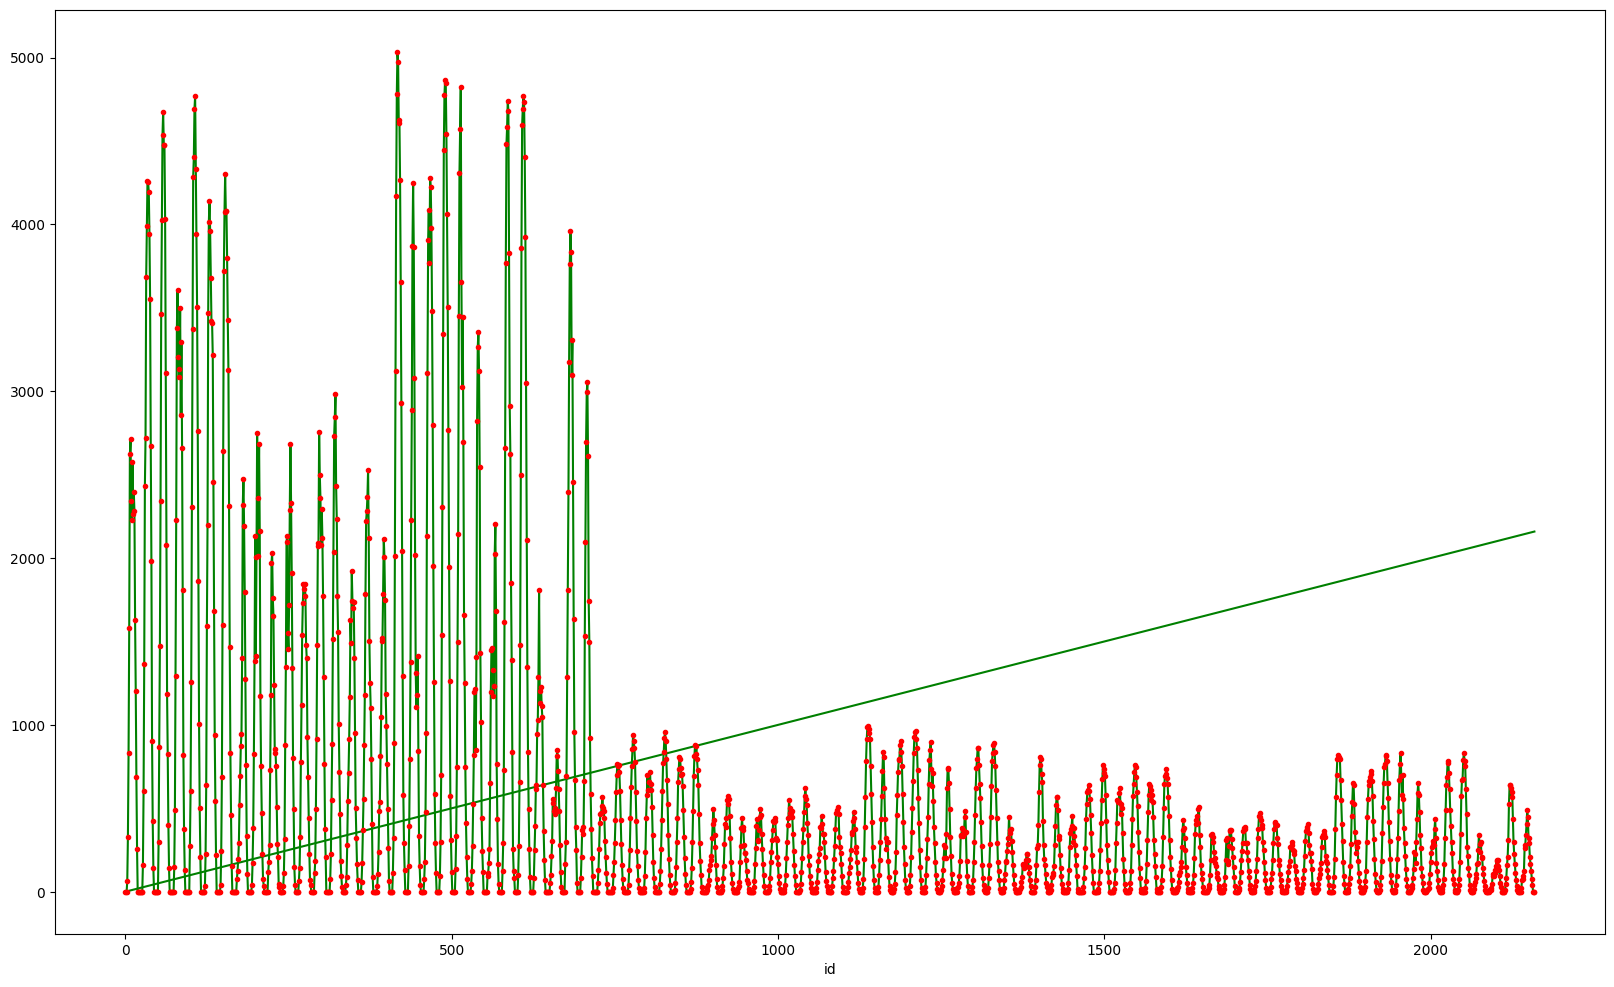

In [34]:
best_submission = pd.read_csv('./final_ag_cat_sub_clean_high.csv')
second_best_sub = pd.read_csv('./final_ag_cat_sub_clean_high_2.csv')

print(y_pred.shape)
print(best_submission['prediction'].shape)
plt.figure(figsize=(20,12))

plt.plot(second_best_sub, 'g')
plt.plot(best_submission['prediction'], 'r.')
plt.xlabel("id")
plt.show()

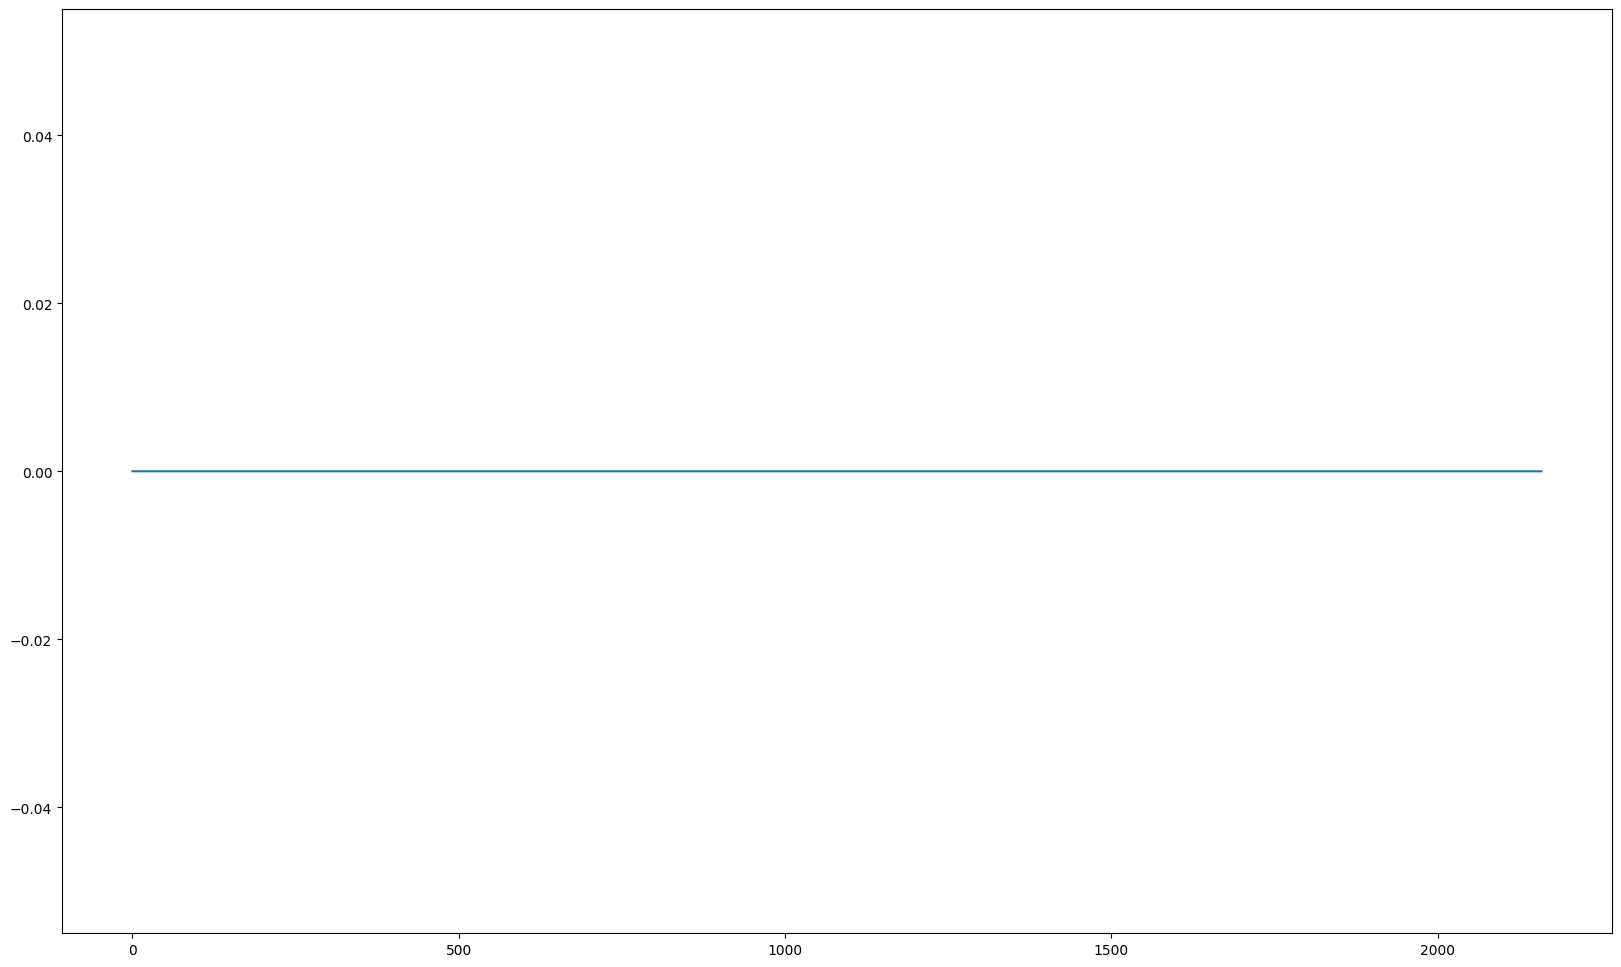

In [35]:
dist = best_submission['prediction'] - second_best_sub['prediction']

plt.figure(figsize=(20,12))
plt.plot(dist)